In [15]:
import os
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation

parent_dir = os.path.dirname(os.getcwd())

# Load the dataset
rating_csv_path = os.path.join(parent_dir, 'dataset', 'rating.csv')
rating_df = pd.read_csv(rating_csv_path)

current_dir = os.getcwd()


# Combine the preprocessed title and content into a single corpus
corpus = rating_df['title'].fillna('') + ' ' + rating_df['content'].fillna('')

# Vectorize the corpus using TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')
tfidf_matrix = tfidf_vectorizer.fit_transform(corpus)

# Apply Latent Dirichlet Allocation (LDA) for topic modeling
lda_model = LatentDirichletAllocation(n_components=5, random_state=42)  # Adjust the number of topics as needed
lda_model.fit(tfidf_matrix)

# Display the top words for each topic
feature_names = tfidf_vectorizer.get_feature_names_out()
n_top_words = 10  # Number of top words to display for each topic
for topic_idx, topic in enumerate(lda_model.components_):
    print(f"Topic {topic_idx+1}:")
    top_words_idx = topic.argsort()[:-n_top_words - 1:-1]
    top_words = [feature_names[i] for i in top_words_idx]
    print(', '.join(top_words))

# Assign topics to articles based on the dominant topic
dominant_topic = lda_model.transform(tfidf_matrix).argmax(axis=1)
rating_df['topic'] = dominant_topic


Topic 1:
nyse, quarter, llc, report, according, shares, recent, free, market, holdings
Topic 2:
nasdaq, report, shares, stock, traded, free, earnings, dividend, nyse, stocknews
Topic 3:
00, price, target, report, nasdaq, reports, research, rating, 2023, free
Topic 4:
israel, gaza, 2023, hamas, war, israeli, november, ukraine, president, minister
Topic 5:
li, new, india, world, year, getty, ai, 2023, said, ul


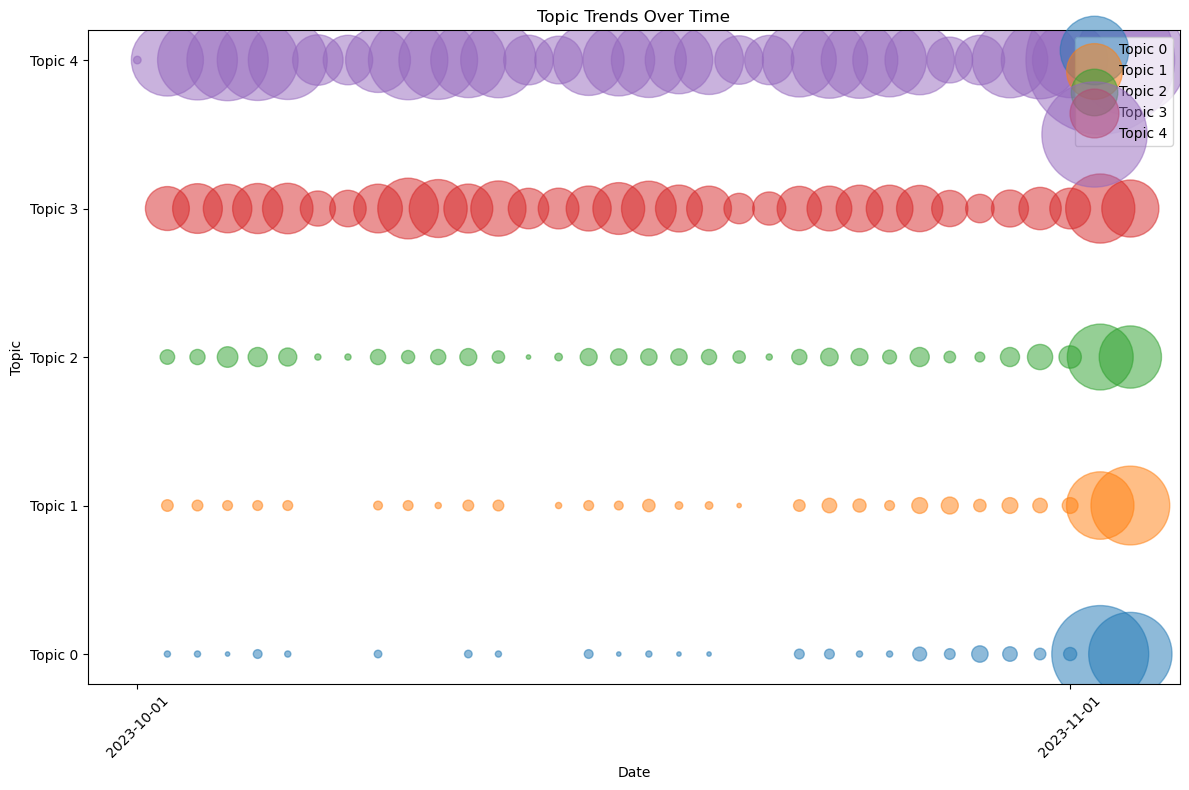

In [17]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# # Load the dataset
# rating_df = pd.read_csv('rating.csv')

# Convert 'published_at' column to datetime with multiple format strings
rating_df['published_at'] = pd.to_datetime(rating_df['published_at'], errors='coerce', format='%Y-%m-%d %H:%M:%S.%f')

# Drop rows with missing or invalid datetime values
data = rating_df.dropna(subset=['published_at'])

# Group the data by date and topic to count occurrences
dominant_topic = data.groupby([data['published_at'].dt.date, 'topic']).size().unstack(fill_value=0)

# Plotting
fig, ax = plt.subplots(figsize=(12, 8))

# Convert date to matplotlib date format
dates = mdates.date2num(dominant_topic.index)

# Plot scatter plot
for i, topic in enumerate(dominant_topic.columns):
    ax.scatter(dates, [i] * len(dominant_topic), s=dominant_topic[topic]*10, alpha=0.5, label=f"Topic {topic}")

# Beautify the plot
ax.set_yticks(range(len(dominant_topic.columns)))
ax.set_yticklabels([f"Topic {topic}" for topic in dominant_topic.columns])
ax.set_xlabel('Date')
ax.set_ylabel('Topic')
ax.set_title('Topic Trends Over Time')
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax.xaxis.set_major_locator(mdates.MonthLocator())

# Add legend
ax.legend()

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Show plot
plt.tight_layout()
plt.show()